<a href="https://colab.research.google.com/github/lkoneha/LLM/blob/main/BERT%2BBidirectional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
df= pd.read_csv('DS4_WELDA.csv')
df.head()

,API,Description,Category,Categoryl
0,Google App Engine API,[This API is no longer available. Its functio...,Tools,0
1,COLOURlovers API,From their site: With the release of the COLO...,Tools,0
2,GitHub API,GitHub is a repository of public open source ...,Tools,0
3,uClassify API,The uClassify API allows you to classify text...,Tools,0
4,Pusher API,"Pusher is a simple hosted API for quickly, ea...",Tools,0


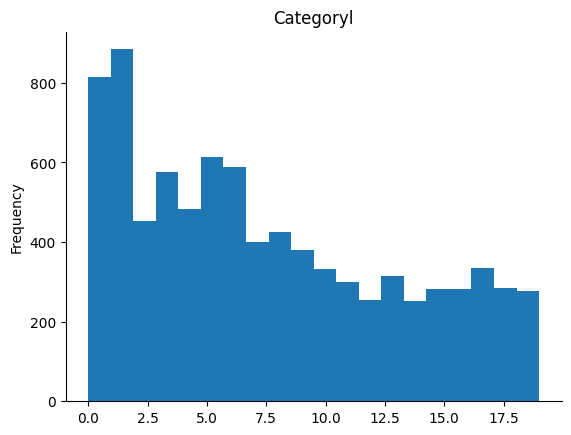

In [5]:
# @title Categoryl

from matplotlib import pyplot as plt
df['Categoryl'].plot(kind='hist', bins=20, title='Categoryl')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [6]:
df['encoded_text']= df['Category'].astype('category').cat.codes
df.head()

,API,Description,Category,Categoryl,encoded_text
0,Google App Engine API,[This API is no longer available. Its functio...,Tools,0,15
1,COLOURlovers API,From their site: With the release of the COLO...,Tools,0,15
2,GitHub API,GitHub is a repository of public open source ...,Tools,0,15
3,uClassify API,The uClassify API allows you to classify text...,Tools,0,15
4,Pusher API,"Pusher is a simple hosted API for quickly, ea...",Tools,0,15


In [8]:
data = df[['Description','encoded_text']]
data.head()

,Description,encoded_text
0,[This API is no longer available. Its functio...,15
1,From their site: With the release of the COLO...,15
2,GitHub is a repository of public open source ...,15
3,The uClassify API allows you to classify text...,15
4,"Pusher is a simple hosted API for quickly, ea...",15


In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

data = data.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string

        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
data['Description'] = data['Description'].apply(clean_text)

In [11]:
texts = data['Description'].tolist()
labels = data['encoded_text'].tolist()

In [12]:
from sklearn.model_selection import train_test_split
texts_trainval, texts_test, labels_trainval, labels_test = train_test_split(texts, labels, test_size=0.2, random_state=42)
texts_train, texts_val, labels_train, labels_val = train_test_split(texts_trainval, labels_trainval, test_size=0.2, random_state=42)


In [13]:
from transformers import BertTokenizer, TFBertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [14]:
def tokenize_texts(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='tf')
    input_ids = inputs['input_ids']
    attention_mask = tf.ones_like(input_ids)
    return input_ids, attention_mask

In [15]:
input_ids_train, attention_mask_train = tokenize_texts(texts_train)
input_ids_val, attention_mask_val = tokenize_texts(texts_val)
input_ids_test, attention_mask_test = tokenize_texts(texts_test)


In [16]:
batch_size = 4 # or smaller if needed

# Limit sequence length
max_seq_length = 32  # or smaller if needed
input_ids_train = input_ids_train[:, :max_seq_length]
attention_mask_train = attention_mask_train[:, :max_seq_length]
input_ids_val = input_ids_val[:, :max_seq_length]
attention_mask_val = attention_mask_val[:, :max_seq_length]
input_ids_test = input_ids_test[:, :max_seq_length]
attention_mask_test = attention_mask_test[:, :max_seq_length]

In [17]:
outputs_train = bert_model(input_ids_train, attention_mask=attention_mask_train)


In [18]:
outputs_val = bert_model(input_ids_val, attention_mask=attention_mask_val)
outputs_test = bert_model(input_ids_test, attention_mask=attention_mask_test)

In [19]:
last_hidden_state_train = outputs_train.last_hidden_state
last_hidden_state_val = outputs_val.last_hidden_state
last_hidden_state_test = outputs_test.last_hidden_state

In [20]:
np.save('train_embeddings.npy', last_hidden_state_train.numpy())
np.save('val_embeddings.npy', last_hidden_state_val.numpy())
np.save('test_embeddings.npy', last_hidden_state_test.numpy())

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.layers import Bidirectional

def create_model():
    input_layer = Input(shape=(None, last_hidden_state_train.shape[-1]))
    lstm_layer= Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2))(input_layer)
    #lstm_layer = Bidirectional(LSTM(128)(input_layer))
    output_layer = Dense(20, activation='softmax')(lstm_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [26]:
classifier = create_model()

# Compile model
classifier.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
classifier.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 768)]       0         
                                                                 
 bidirectional (Bidirection  (None, 200)               695200    
 al)                                                             
                                                                 
 dense (Dense)               (None, 20)                4020      
                                                                 
Total params: 699220 (2.67 MB)
Trainable params: 699220 (2.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
print(type(last_hidden_state_train))
print(type(labels_train))

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'list'>


In [28]:
labels_train = tf.convert_to_tensor(labels_train)


In [29]:
labels_val = tf.convert_to_tensor(labels_val)
labels_test = tf.convert_to_tensor(labels_test)

In [30]:
classifier.fit(last_hidden_state_train, labels_train, validation_data=(last_hidden_state_val, labels_val), epochs=20, batch_size=128)


Epoch 1/20
43/43 [==============================] - 20s 266ms/step - loss: 2.4398 - accuracy: 0.2662 - val_loss: 2.0154 - val_accuracy: 0.3927
Epoch 2/20
43/43 [==============================] - 11s 264ms/step - loss: 1.7087 - accuracy: 0.4840 - val_loss: 1.7557 - val_accuracy: 0.4806
Epoch 3/20
43/43 [==============================] - 8s 192ms/step - loss: 1.4665 - accuracy: 0.5571 - val_loss: 1.6671 - val_accuracy: 0.4923
Epoch 4/20
43/43 [==============================] - 7s 169ms/step - loss: 1.2587 - accuracy: 0.6170 - val_loss: 1.5460 - val_accuracy: 0.5414
Epoch 5/20
43/43 [==============================] - 8s 197ms/step - loss: 1.1009 - accuracy: 0.6668 - val_loss: 1.4738 - val_accuracy: 0.5619
Epoch 6/20
43/43 [==============================] - 8s 193ms/step - loss: 0.9559 - accuracy: 0.7062 - val_loss: 1.5253 - val_accuracy: 0.5429
Epoch 7/20
43/43 [==============================] - 7s 168ms/step - loss: 0.8532 - accuracy: 0.7364 - val_loss: 1.4464 - val_accuracy: 0.5648
Epoc

In [31]:
loss, accuracy = classifier.evaluate(last_hidden_state_test, labels_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

54/54 [==============================] - 1s 24ms/step - loss: 1.9134 - accuracy: 0.5718
Test Loss: 1.9134477376937866, Test Accuracy: 0.5717633366584778
